$$
\newcommand{\nants}{N_{ants}}
\newcommand{\npols}{N_{pols}}
\newcommand{\nfreqs}{N_{freqs}}
\newcommand{\ntimes}{N_{times}}
$$
The purpose of this notebook is to provide a template for visualizing RFI from narrowband transmitters. It works by searching for a particular file within the current working directory, loading that file, then performing a standard analysis on the data and plotting the results. For an array with $\nants$ antennas and $\npols$ visibility polarizations, which measures $\ntimes$ integrations per night using a correlator with $\nfreqs$ frequency channels, the data hypercube for a single night has shape $(\nants(\nants+1)^2/2, \ntimes, \nfreqs, \npols)$, or some reshaping thereof.  The analysis is currently performed only on autocorrelations and linear polarizations, so the data cubes used in this analysis have shape $(\nants, \ntimes, \nfreqs, 2)$. Since plots tend to become overwhelming when we try to include more than two independent axes, we must work with various projections or summary statistics that reduce the dimensionality of the data when visualizing the results for the entire array. This notebook serves to provide some of the most useful plots for understanding narrowband RFI&mdash;that is, RFI that is persistent and confined to a small range of frequencies.

In [1]:
import copy
import itertools
import os
import re
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from astropy import units

import uvtools
from pyuvdata import UVData
from hera_mc import cm_hookup

%matplotlib inline

### Utility Functions

In [2]:
def get_ant_to_node_map():
    """Get a dictionary mapping antenna numbers to node numbers."""
    
    # load in the hookup information for HERA, as of now
    db_hookup = cm_hookup.Hookup()
    
    # take only the antenna/node information from the hookup table
    hookup_dict = db_hookup.get_hookup("HH")
    ant_to_node_table = db_hookup.show_hookup(
        hookup_dict, cols_to_show=("antenna", "node")
    )
    
    # use regular expressions to pull the antenna/node numbers
    ant_pattern = re.compile("A[0-9]+")
    node_pattern = re.compile("N[0-9]+")
    ants = ant_pattern.findall(ant_to_node_table)
    nodes = node_pattern.findall(ant_to_node_table)

    # convert the antennas/nodes to integers (for simplifying their use)
    ants = [int(ant[1:]) for ant in ants] # remove the leading A
    nodes = [int(node[1:]) for node in nodes] # remove the leading N
    
    # return the ant : node mapping
    return dict(zip(ants, nodes))

In [3]:
def get_ant_to_snap_map():
    """Get a dictionary mapping antenna numbers to SNAP numbers."""
    
    # load in the hookup information for HERA, as of now
    db_hookup = cm_hookup.Hookup()
    
    # take only the antenna/node information from the hookup table
    hookup_dict = db_hookup.get_hookup("HH")
    ant_to_snap_table = db_hookup.show_hookup(
        hookup_dict, cols_to_show=("antenna", "snap")
    )
    
    # use regular expressions to pull the antenna/node numbers
    ant_pattern = re.compile("A[0-9]+")
    snap_pattern = re.compile("SNP[A,C][0-9]+")
    ants = ant_pattern.findall(ant_to_snap_table)
    snaps = snap_pattern.findall(ant_to_snap_table)

    # convert the antennas to integers (for simplifying their use)
    ants = [int(ant[1:]) for ant in ants] # remove the leading A
    
    # return the ant : node mapping
    return dict(zip(ants, snaps))

In [4]:
def sort_by_node(data, antennas, node_to_ant_map):
    """Sort a data array by node number.
    
    Assumes that the zeroth axis of the data runs along antennas.
    """
    if not isinstance(antennas, list):
        antennas = list(antennas)
    # be aware of using log scale or not
    sorted_data = np.zeros_like(data) if data.min() == 0 else np.ones_like(data)
    rownum = 0
    for ants in node_to_ant_map.values():
        for ant in ants:
            if ant not in antennas: continue
            ant_ind = antennas.index(ant)
            sorted_data[rownum] = data[ant_ind]
            rownum += 1
    return sorted_data

In [5]:
def plot_channelized_data(data, data_bounds=None, figsize=None,
                          nrows=None, ncols=None, pols=None, 
                          xlabel=None, ylabel=None, extent=None,
                          xvals=None, yvals=None,
                          xticklabels=None, yticklabels=None,
                          cbar_labels=None, cmaps=None,
                          gridspec_kws=None):
    """Plot data that is channelized along one or two axes.
    
    This function generates a figure following a particular format: 
    Each row of plots corresponds to a different quantity.
    Each column of plots corresponds to a different polarization.
    One colorbar is used per row.
    """
    # some setup stuff
    if type(data) is np.ndarray:
        data = (data,)
    data = tuple(np.atleast_3d(data_) for data_ in data)
    
    nrows = nrows or len(data)
    ncols = ncols or data[0].shape[-1]
    pols = pols or (None,) * ncols
    data_bounds = data_bounds or ((None,) * ncols,) * nrows
    
    figsize = figsize or (15 * ncols, 10 * nrows)
    gridspec_kws = gridspec_kws or {}
    
    cbar_labels = cbar_labels or (None,) * nrows
    cmaps = cmaps or ("inferno",) * nrows
    if extent is None:
        if xvals is not None:
            x_extent = (xvals[0], xvals[-1])
        else:
            x_extent = (0, len(xticklabels))
        if yvals is not None:
            y_extent = (yvals[-1], yvals[0])
        else:
            y_extent = (len(yticklabels), 0)
        extent = x_extent + y_extent
        
    # create the figure
    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows, ncols, gridspec_kw=gridspec_kws)
    if axes.ndim == 1:
        axes = np.asarray([axes])
        # get the orientation right
        axes = axes.T if ncols == 1 else axes
    
    # actually plot stuff
    for count, ax in enumerate(axes.ravel()):
        rownum = count // ncols
        colnum = count % ncols
        
        # note the polarizations
        if rownum == 0:
            if pols[colnum] is not None:
                title = "%s Polarization" % pols[colnum]
                ax.set_title(title, fontsize=12)
        
        # add labels where appropriate
        if rownum == nrows - 1:
            ax.set_xlabel(xlabel, fontsize=12)
        if colnum == 0:
            ax.set_ylabel(ylabel, fontsize=12)
            
        # prepare data and colormap
        use_data = data[rownum][:, :, colnum]
        vmin, vmax = data_bounds[rownum]
        cmap = cmaps[rownum]
        
        # actually plot it
        cax = ax.imshow(
            use_data, aspect='auto', extent=extent, 
            cmap=cmap, vmin=vmin, vmax=vmax, 
        )
        
        # label channels for any channelized axes
        if xticklabels is not None:
            xticks = np.arange(len(xticklabels)) + 0.5
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels, rotation='vertical')
        if yticklabels is not None:
            yticks = np.arange(len(yticklabels)) + 0.5
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            
        # add a colorbar after finishing a row
        if colnum == ncols - 1:
            cbar = fig.colorbar(cax, ax=axes[rownum], pad=0.01)
            cbar.set_label(cbar_labels[rownum], fontsize=12)
            
    return fig

### Data Preparation

In [6]:
# summary file from night of observing will use the following naming convention:
# zen.<jd>.rfi_stations.uvh5
# where <jd> is the Julian Date of the observation

class PipelineError(Exception):
    pass

# pull the information for finding the file
try:
    # follow Lindsay's example
    dpath = os.environ['DATA_PATH']
    jd = os.environ['JULIANDATE']
    
    # check that the file exists
    filename = os.path.join(dpath, "zen.{jd}.rfi_stations.uvh5".format(jd=jd))
    if not os.path.exists(filename):
        raise FileNotFoundError
except (KeyError, FileNotFoundError) as err:
    # something broke, so find out what went wrong and report it
    if type(err) is KeyError:
        msg = "Environment not correctly configured; could not find either data path or JD."
    else:
        msg = "Summary file does not exist in {data_dir}.".format(data_dir=dpath)
    raise PipelineError(msg)

In [7]:
# assuming all is well, load in the data
uvd = UVData()
uvd.read(filename, ant_str='auto')

In [8]:
# pull the metadata
freqs = uvd.freq_array.flatten()
freqs_MHz = freqs / 1e6

lsts = np.unique(uvd.lst_array)
lsts_hr = lsts * units.sday.to('hr') / (2 * np.pi)

times = np.unique(uvd.time_array)
plot_times = times - np.floor(times[0])

ants_to_nodes = get_ant_to_node_map()
antpairs = uvd.get_antpairs()
antennas = list([antpair[0] for antpair in antpairs])
pols = uvd.get_pols()

Nants = uvd.Nants_data
Nfreqs = uvd.Nfreqs
Ntimes = uvd.Ntimes
Npols = uvd.Npols
Nantpols = Nants * Npols

In [9]:
# make the visibility data cube
vis_data_cube = np.zeros(
    (Nants, Ntimes, Nfreqs, Npols), 
    dtype=np.float
)

for i, antpair in enumerate(antpairs):
    for j, pol in enumerate(pols):
        antpairpol = antpair + (pol,)
        vis_data_cube[i, :, :, j] = np.abs(uvd.get_data(antpairpol))
        
# we'll be using lots of log scales, so make sure there are no zeros in the data
vis_data_cube[vis_data_cube == 0] = 1

# get the flags from the data cube
rfi_flags = np.where(vis_data_cube > 1, True, False)

Let's calculate some different quantities that will be useful. More quantities may be added to this collection later, but for the time being we'll be looking at:
* Transmitter duty cycles (how often the transmitter is on) on a per-antpol basis
* Time-averaged (mean) transmitter strengths on a per-antpol basis
* Transmitter time series (median over antennas) on a per-pol basis
* Transmitter signal amplitudes (maximum over time) on a per-antpol basis
* Transmitter signal standard deviations over time (only when transmitter is on) on a per-antpol basis

In [10]:
# extract the transmitter data

# how often a given channel is flagged over the course of a night
duty_cycles = rfi_flags.mean(axis=1)

# impose a cut on duty cycles to identify transmitters; default to 10%
duty_cycle_cut = float(os.environ.get('DUTY_CYCLE_CUT', 0.1))
has_transmitter = np.where(duty_cycles > duty_cycle_cut, True, False)

# do a logical OR over all antpols to find transmitters
transmitter_channels = np.argwhere(has_transmitter.sum(axis=0).sum(axis=1).astype(bool)).flatten()
transmitter_freqs = freqs_MHz[transmitter_channels]
transmitter_duty_cycles = duty_cycles[:, transmitter_channels, :]
transmitter_data_cube = vis_data_cube[:, :, transmitter_channels, :]

In [11]:
# actually compute some things

# do a median over antennas as a proxy for each transmitter's time series
median_transmitter_time_series = np.median(transmitter_data_cube, axis=0)
# shape (Ntimes, Nfreqs, Npols)

# take a time average to get some antenna diagnostics
time_averaged_transmitter_data = transmitter_data_cube.mean(axis=1)
# shape (Nants, Nfreqs, Npols)

# find out the maximum brightness for each transmitter as measured by each antpol
transmitter_amplitudes = transmitter_data_cube.max(axis=1)
# shape (Nants, Nfreqs, Npols)

# find out how the transmitter strengths vary on a per-antpol basis
transmitter_standard_deviations = np.ones_like(transmitter_amplitudes)
fractional_transmitter_standard_deviations = np.zeros_like(transmitter_amplitudes)
# shape (Nants, Nfreqs, Npols)
for i in range(Nants):
    for j in range(transmitter_freqs.size):
        for k in range(Npols):
            use_data = transmitter_data_cube[i, :, j, k]
            # catch cases where an antpol didn't actually observe RFI
            # this can either be due to a malfunctioning antenna
            # or because the transmitter is internal RFI picked up
            # by only a handful of antennas
            if use_data[use_data != 1].size <= 1: 
                continue
            # calculate the standard deviation in signal strength
            # but *only when the transmitter is on*
            transmitter_standard_deviations[i,j,k] = use_data[use_data != 1].std()
            fractional_transmitter_standard_deviations[i,j,k] = \
                transmitter_standard_deviations[i,j,k] / transmitter_amplitudes[i,j,k]

In [12]:
# invert the ant -> node mapping
node_to_ant_map = {node : [] for node in ants_to_nodes.values()}
for ant, node in ants_to_nodes.items():
    node_to_ant_map[node].append(ant)
node_to_ant_map = {
    node : sorted(list(set(ants))) for node, ants in node_to_ant_map.items()
}

### Data Visualization

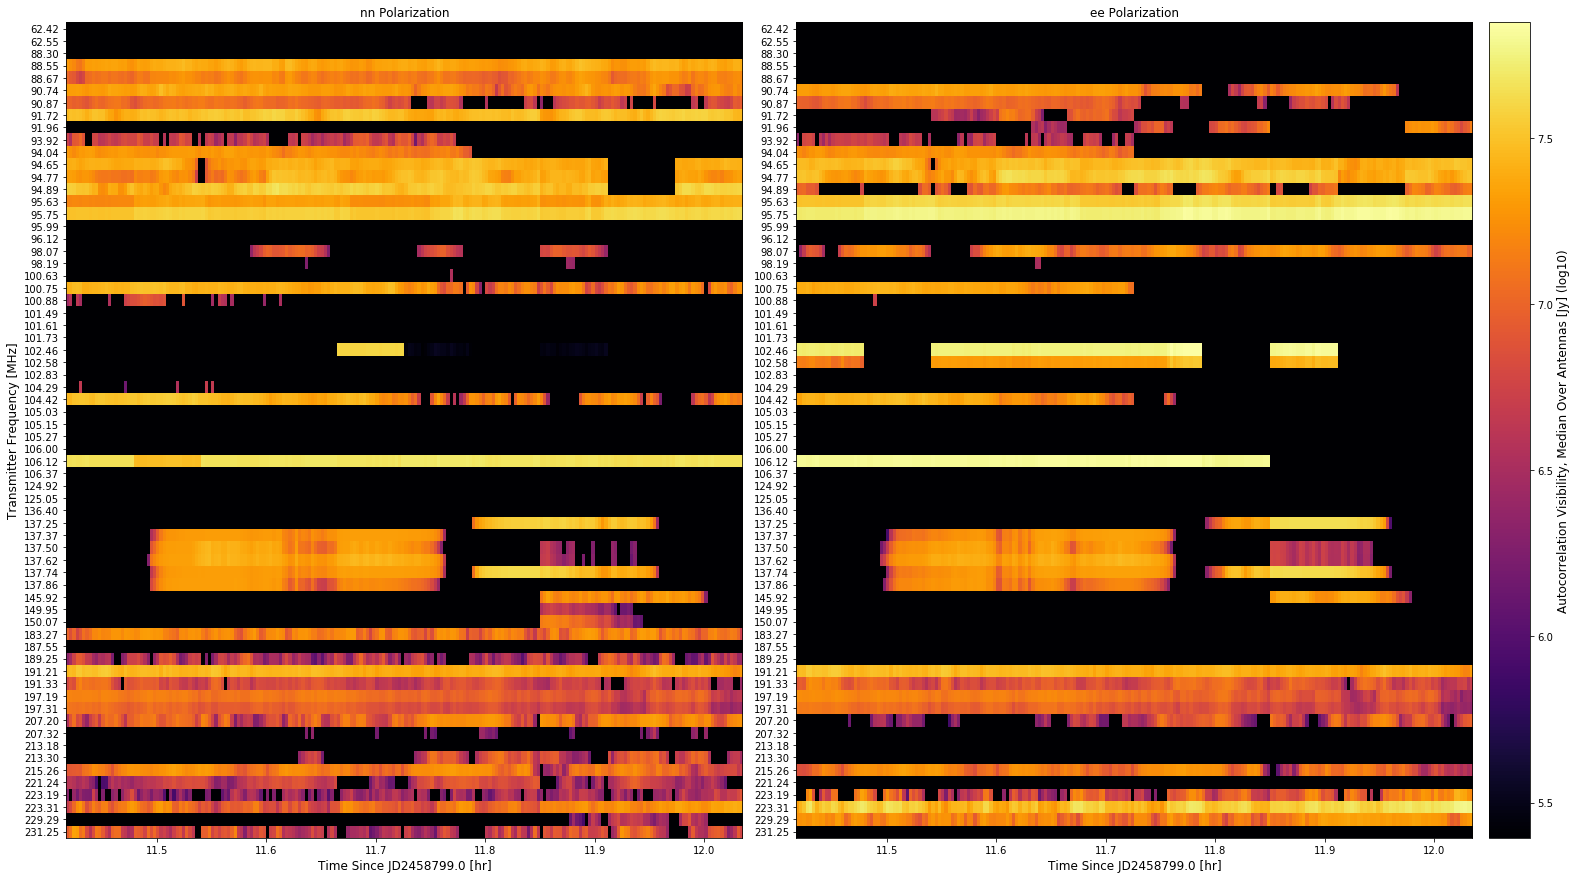

In [13]:
# make the plots, starting with the time series
plot_data = np.swapaxes(
    np.log10(median_transmitter_time_series), 0, 1
)
data_bounds = (plot_data[plot_data != 0].min(), plot_data.max())

plot_kwargs = {"data_bounds" : (data_bounds,)}

# configure x-axis
plot_kwargs['xlabel'] = "Time Since JD%.1f [hr]" % np.floor(times[0])
plot_kwargs['xvals'] = plot_times * units.day.to('hr')

# configure y-axis
plot_kwargs['ylabel'] = "Transmitter Frequency [MHz]"
plot_kwargs['yticklabels'] = ["%.2f" % fq for fq in transmitter_freqs]

# extra parameters
plot_kwargs['cbar_labels'] = ("Autocorrelation Visibility, Median Over Antennas [Jy] (log10)",)
plot_kwargs['pols'] = pols
plot_kwargs['gridspec_kws'] = {"wspace" : 0.08}
plot_kwargs['figsize'] = (30, 15)

fig = plot_channelized_data(plot_data, **plot_kwargs)

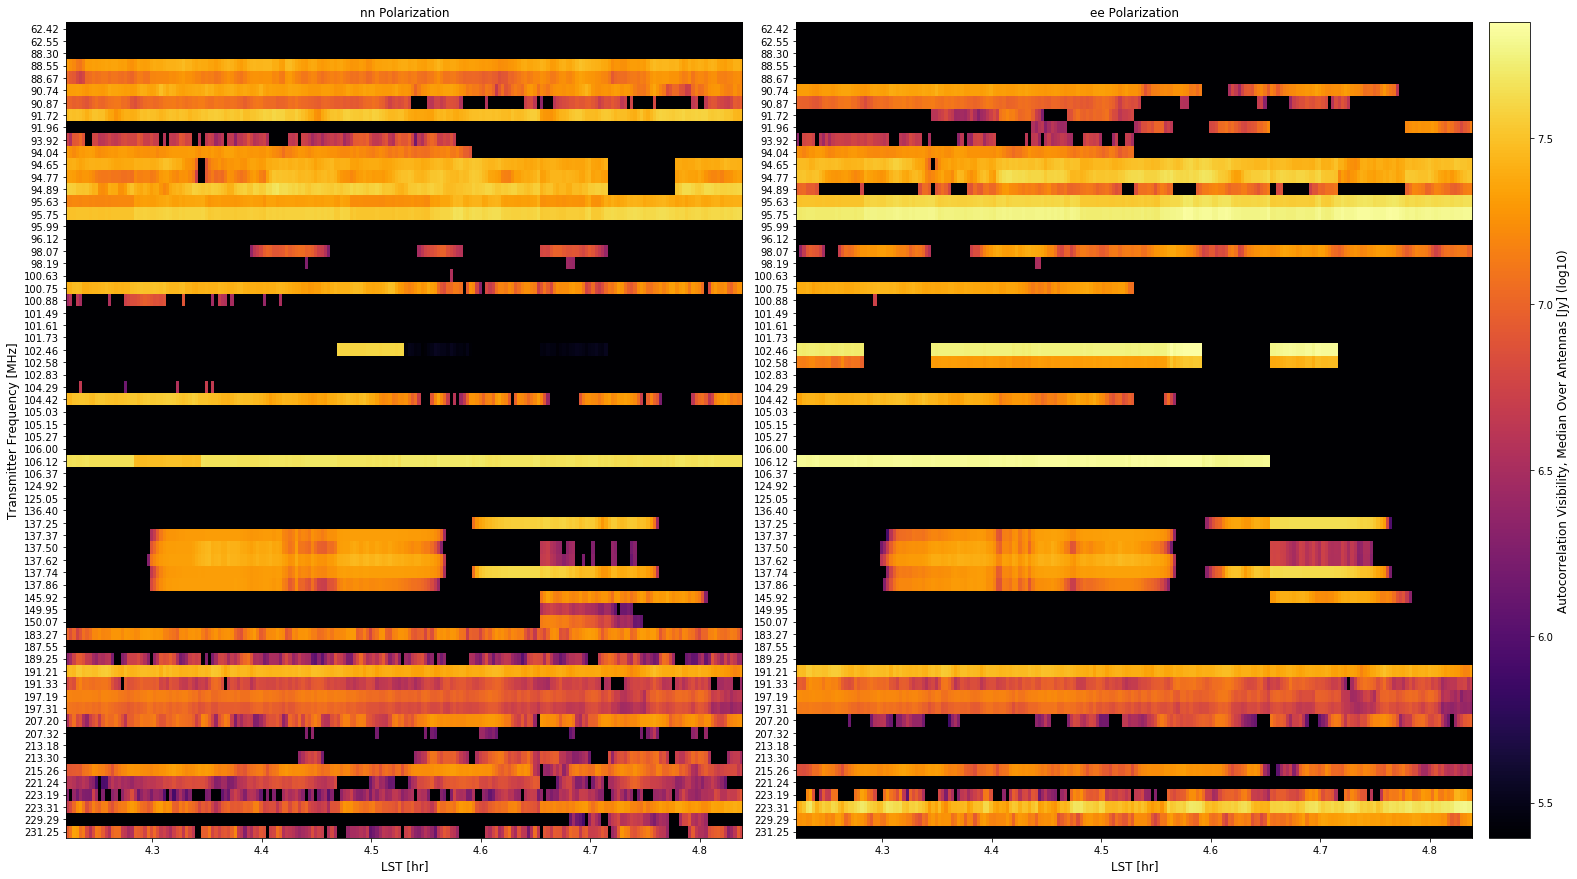

In [14]:
# remake the above plot, but use lsts instead
plot_kwargs['xlabel'] = "LST [hr]"
plot_kwargs['xvals'] = lsts_hr
fig = plot_channelized_data(plot_data, **plot_kwargs)

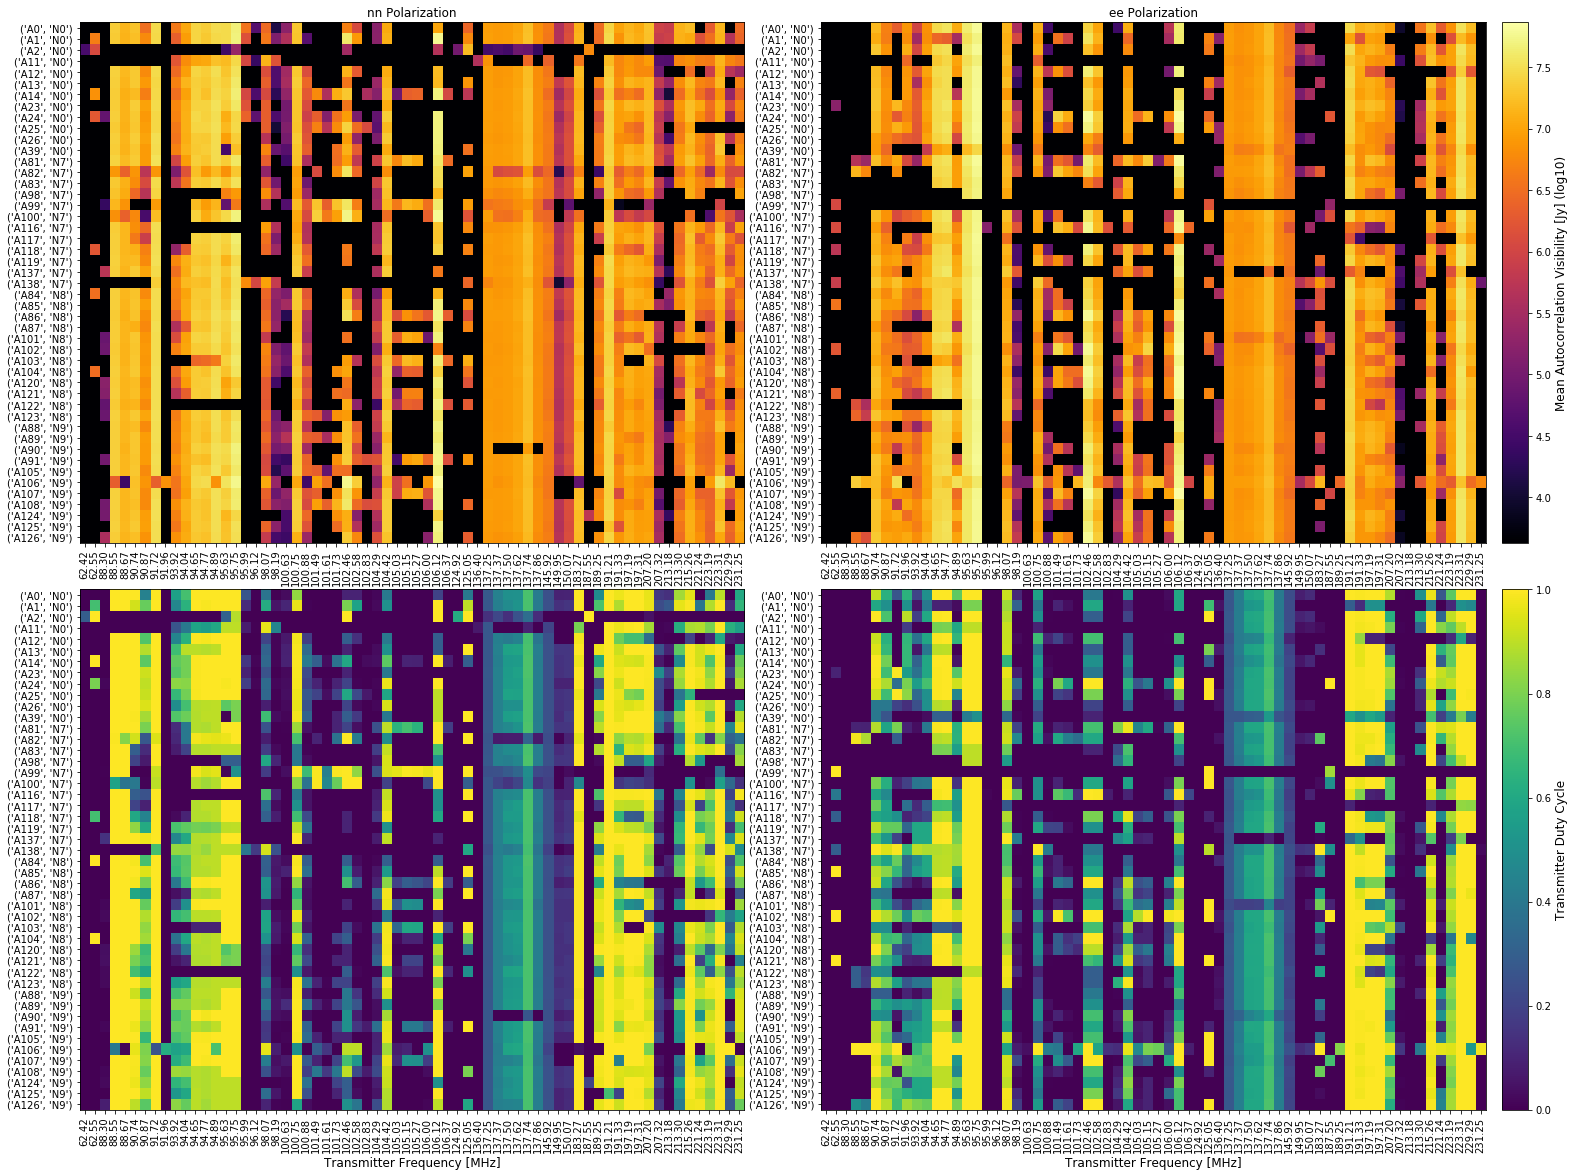

In [15]:
# now some of the summary plots
plot_data = (
    np.log10(time_averaged_transmitter_data), 
    transmitter_duty_cycles
)

plot_data = tuple(
    sort_by_node(data, antennas, node_to_ant_map) 
    for data in plot_data
)

plot_kwargs = {'pols' : pols}
plot_kwargs['data_bounds'] = (
    (plot_data[0][plot_data[0] != 0].min(), plot_data[0].max()),
    (0, 1)
)

# configure x-axis
plot_kwargs['xvals'] = None
plot_kwargs['xticklabels'] = ["%.2f" % fq for fq in transmitter_freqs]
plot_kwargs['xlabel'] = "Transmitter Frequency [MHz]"

# configure y-axis
plot_kwargs['yvals'] = None
plot_kwargs['ylabel'] = None
plot_kwargs['yticklabels'] = [
    ("A%d" % ant, "N%d" % node)
    for node, ants in node_to_ant_map.items()
    for ant in ants if ant in antennas
]

# configure extras
plot_kwargs['cbar_labels'] = (
    "Mean Autocorrelation Visibility [Jy] (log10)",
    "Transmitter Duty Cycle"
)
plot_kwargs['cmaps'] = ("inferno", "viridis")
plot_kwargs['gridspec_kws'] = {"wspace" : 0.115, "hspace" : 0.09}
plot_kwargs['figsize'] = None

fig = plot_channelized_data(plot_data, **plot_kwargs)

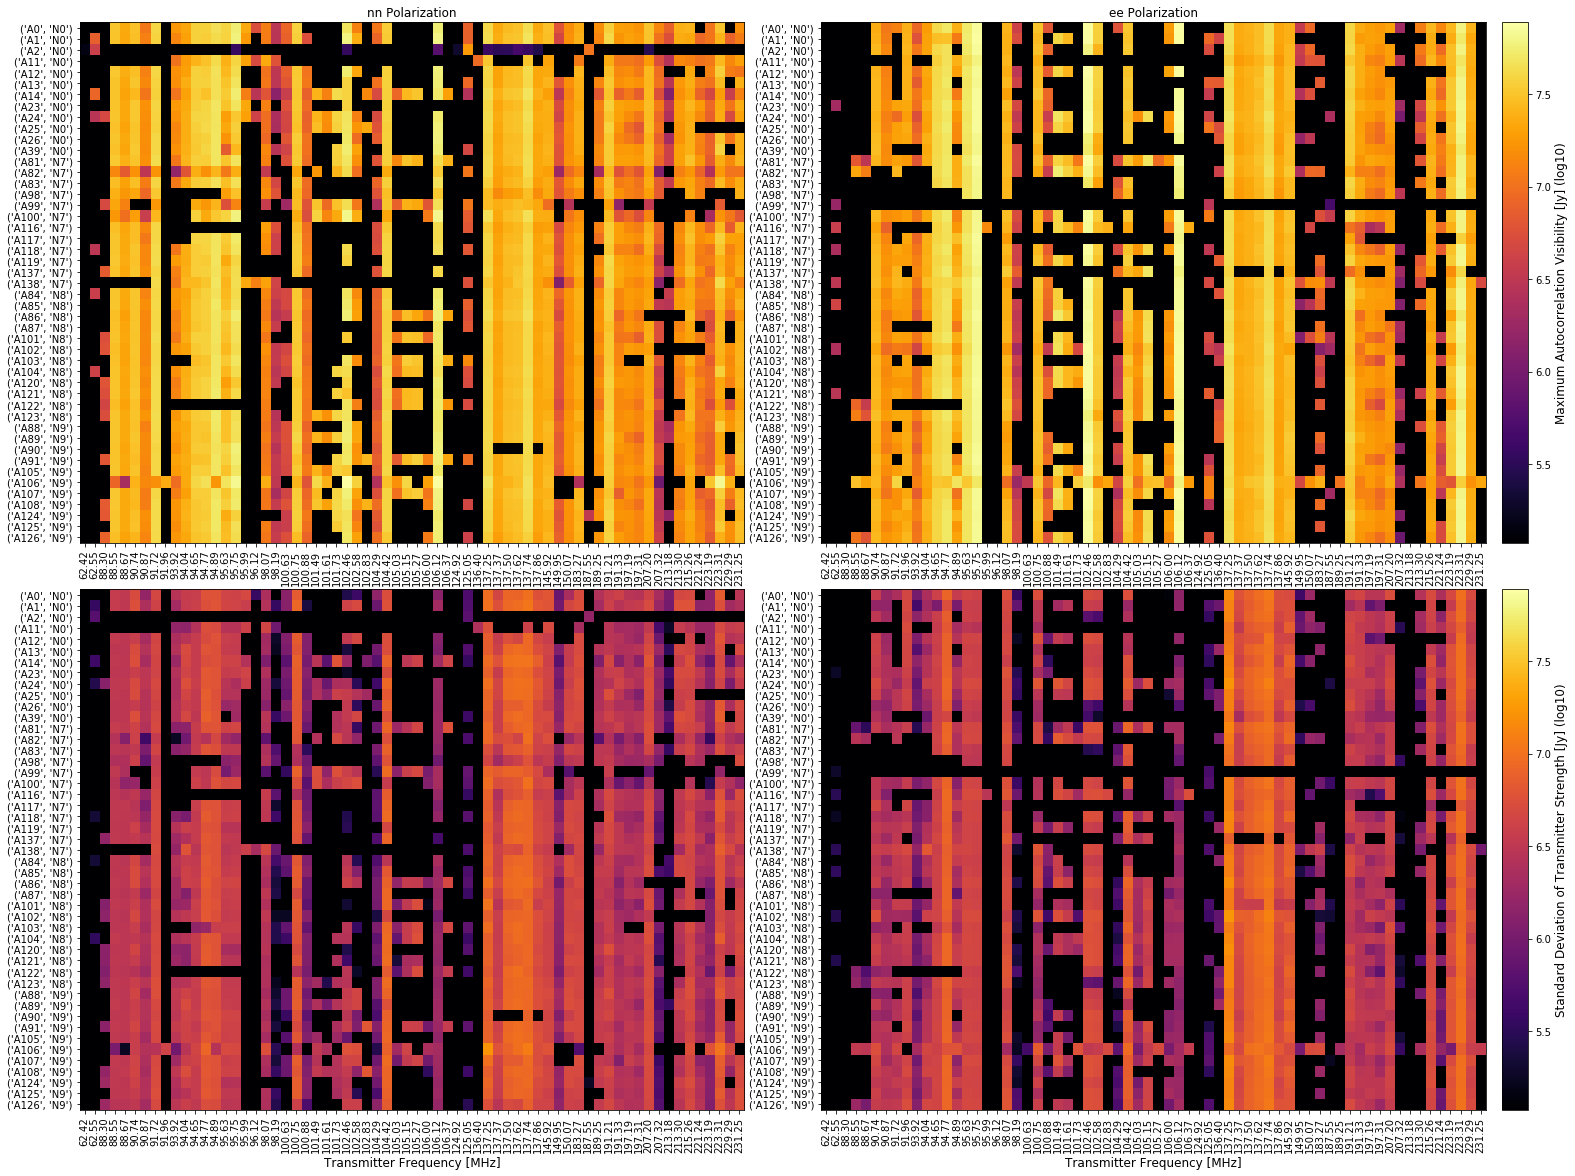

In [16]:
# now the transmitter amplitudes and standard deviations
plot_data = (
    transmitter_amplitudes, transmitter_standard_deviations
)

plot_data = tuple(
    sort_by_node(np.log10(data), antennas, node_to_ant_map) 
    for data in plot_data
)

plot_kwargs['data_bounds'] = (
    (plot_data[0][plot_data[0] != 0].min(), plot_data[0].max()),
) * 2

# use same x- and y-axis configurations from before, but update other stuff
plot_kwargs['cbar_labels'] = (
    "Maximum Autocorrelation Visibility [Jy] (log10)",
    "Standard Deviation of Transmitter Strength [Jy] (log10)"
)
plot_kwargs['cmaps'] = None

fig = plot_channelized_data(plot_data, **plot_kwargs)

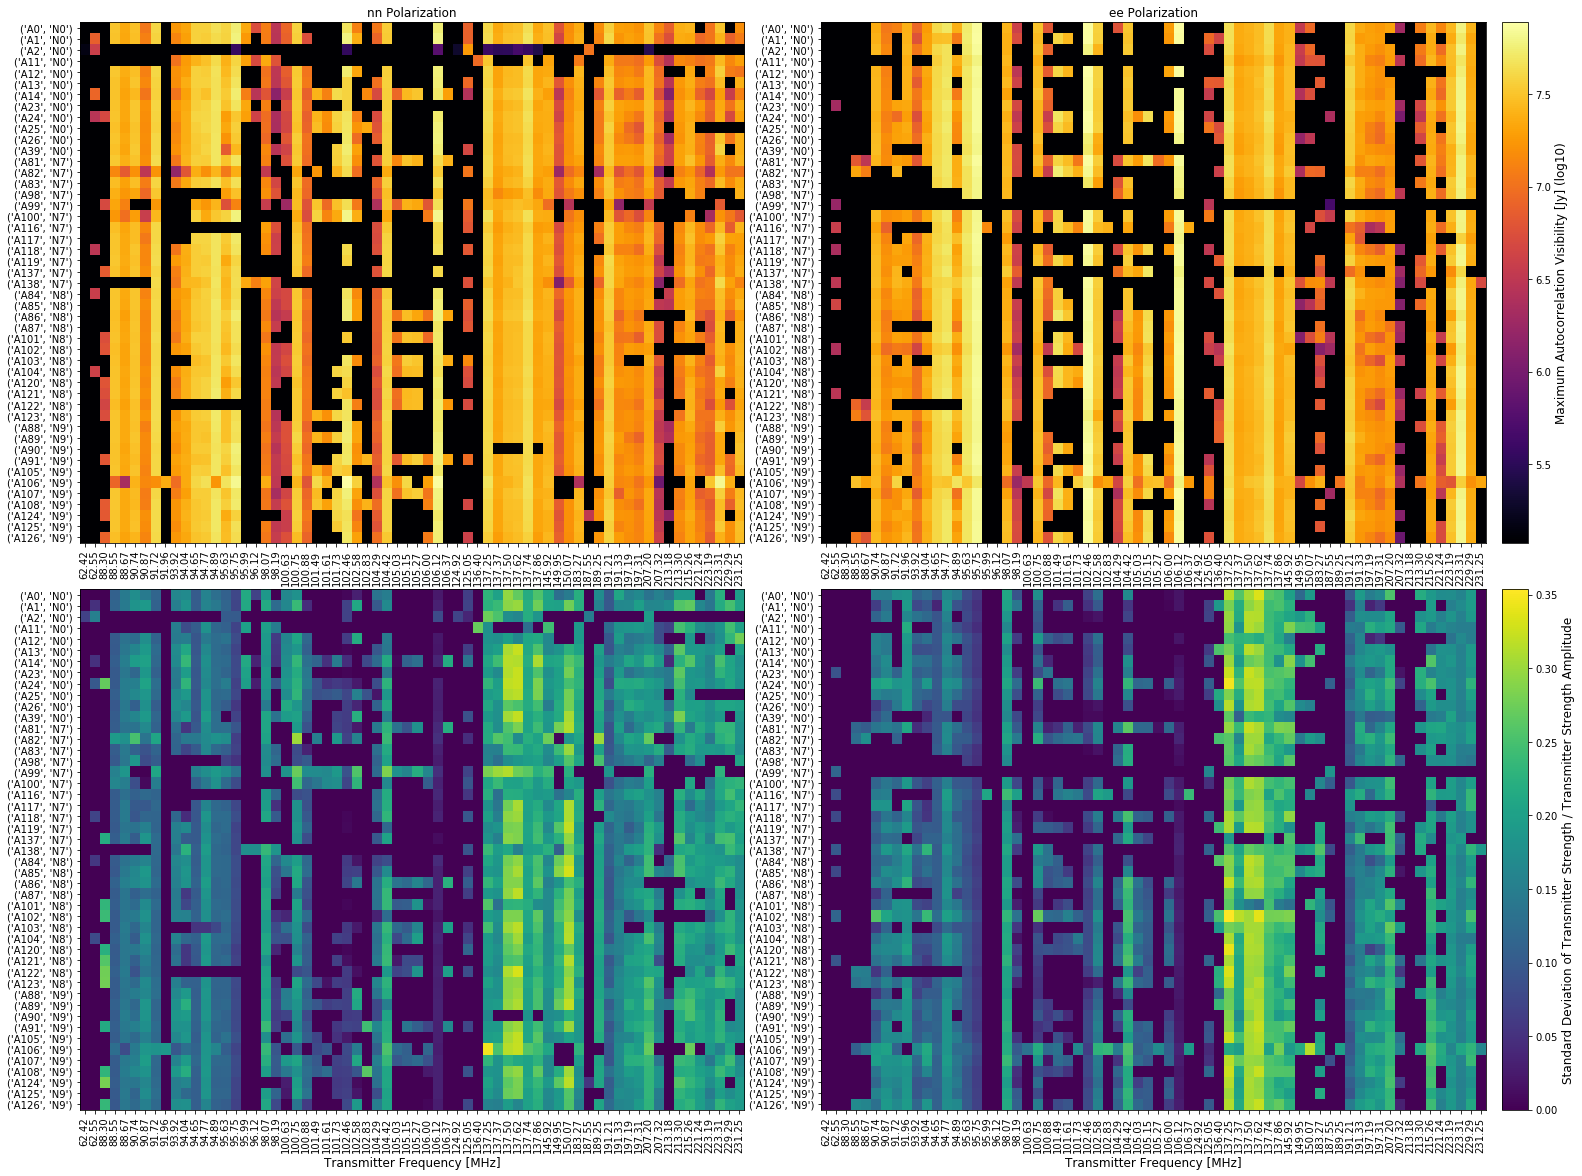

In [17]:
# same plots as above, but show standard deviation as fraction of transmitter amplitude
plot_data = (
    np.log10(transmitter_amplitudes), 
    fractional_transmitter_standard_deviations
)

plot_data = tuple(
    sort_by_node(data, antennas, node_to_ant_map) 
    for data in plot_data
)

plot_kwargs['data_bounds'] = (
    (plot_data[0][plot_data[0] != 0].min(), plot_data[0].max()),
    (0, plot_data[1].max())
)

# use same x- and y-axis configurations from before, but update other stuff
plot_kwargs['cbar_labels'] = (
    "Maximum Autocorrelation Visibility [Jy] (log10)",
    "Standard Deviation of Transmitter Strength / Transmitter Strength Amplitude"
)
plot_kwargs['cmaps'] = ("inferno", "viridis")

fig = plot_channelized_data(plot_data, **plot_kwargs)

In [18]:
# print the hookup info for reference
db_hookup = cm_hookup.Hookup()
hookup_dict = db_hookup.get_hookup("HH")
cols_to_show = ('antenna', 'feed', 'front-end', 'node-bulkhead', 'post-amp', 'snap', 'node')
print(db_hookup.show_hookup(hookup_dict, cols_to_show=cols_to_show))

| antenna   | feed   | front-end   | node-bulkhead   | post-amp   | snap       | node   |
|-----------+--------+-------------+-----------------+------------+------------+--------|
| A0        | FDV1   | FEM016      | NBP00           | PAM022     | SNPC000072 | N00    |
| A0        | FDV1   | FEM016      | NBP00           | PAM022     | SNPC000072 | N00    |
| A1        | FDV2   | FEM018      | NBP00           | PAM024     | SNPC000072 | N00    |
| A1        | FDV2   | FEM018      | NBP00           | PAM024     | SNPC000072 | N00    |
| A2        | FDV8   | FEM040      | NBP00           | PAM048     | SNPC000072 | N00    |
| A2        | FDV8   | FEM040      | NBP00           | PAM048     | SNPC000072 | N00    |
| A11       | FDV9   | FEM045      | NBP00           | PAM052     | SNPA000008 | N00    |
| A11       | FDV9   | FEM045      | NBP00           | PAM052     | SNPA000008 | N00    |
| A12       | FDV3   | FEM041      | NBP00           | PAM050     | SNPA000008 | N00    |
| A12     

In [19]:
# make a summary table?